In [78]:
import os
import time
import gym
import pybullet_envs
import argparse

In [82]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal

In [83]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [84]:
from common.multiprocessing_env import SubprocVecEnv

num_envs = 16
env_name = "MinitaurBulletEnv-v0"
'''
def make_env():
    def _thunk():
        env = gym.make(env_name)
        return env

    return _thunk
    
envs = [make_env() for _ in range(num_envs)]
# Environment for train
envs = SubprocVecEnv(envs)
'''
# Environment for test
env = gym.make(env_name)
'''
envs = [make_envs(env_name) for _ in range(num_envs)]
# Environment for train
envs = SubprocVecEnv(envs)
# Environment for test
env = gym.make(env_name)
'''
print(env.reset())
print(env.action_space.sample())

urdf_root=/home/hskim/.local/lib/python3.8/site-packages/pybullet_data
[ 1.49284070e+00  1.48301870e+00  1.48795567e+00  1.47997667e+00
  1.49567812e+00  1.49991164e+00  1.49529367e+00  1.49670038e+00
  7.51461477e-01  7.58814933e-01  7.67292274e-01  7.71045025e-01
  6.87669100e-01  6.72460822e-01  7.02567450e-01  6.84374201e-01
  5.04306704e-01  5.81597750e-01  5.41054292e-01  6.04026314e-01
  4.89663105e-01  4.58249349e-01  4.90606432e-01  4.82171607e-01
 -1.34587996e-03  1.01803375e-03 -1.76127093e-04  9.99998561e-01]
[ 0.32500744  0.40957657 -0.46784267  0.0525975  -0.28107545  0.8513447
  0.10741148 -0.95063764]


In [85]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
print(f"Run using {device}")

Run using cuda


In [86]:
class Actor(nn.Module):
    def __init__(self, obs_size, act_size):
        super(Actor, self).__init__()

        self.base = nn.Sequential(
            nn.Linear(obs_size, 128),
            nn.ReLU()
        )

        self.mu = nn.Sequential(
            nn.Linear(128, act_size),
            nn.Tanh()                        
        )

        self.var = nn.Sequential(
            nn.Linear(128, act_size),
            nn.Softplus()
        )

    def forward(self, x):
        base_out = self.base(x)
        mu = self.mu(base_out)
        var = self.var(base_out)
        dist = Normal(mu, var)
        return dist

In [87]:
class Critic(nn.Module):
    def __init__(self, input_shape):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_shape, 128),            
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
    def forward(self, x):
        value = self.net(x)
        return value

In [88]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title(f"Frame {frame_idx} reward :{rewards[-1]}")
    plt.plot(rewards)
    plt.show()

In [98]:
def test_env(vis=False):
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        state = torch.tensor(state, dtype=torch.float).unsqueeze(0).to(device)
        dist = actor(state)        
        actions = dists.sample()        
        actions_np = actions.cpu().numpy()
        actions_np = np.clip(actions_np, -1, 1)

        next_state, reward, done, _ = env.step(actions_np)
        state = next_state
        if vis:env.render()
        total_reward += reward
    return total_reward

In [99]:
def compute_returns(next_values, rewards, masks, gamma=0.99):
    R = next_values
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

In [100]:
input_shape = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]

num_steps = 5
actor = Actor(input_shape, n_actions).to(device)
critic = Critic(input_shape).to(device)

actor_optimizer = optim.Adam(actor.parameters(), lr=1e-4)
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

In [101]:
test_state = env.reset()
test_state_tensor = torch.tensor(test_state, dtype=torch.float).to(device)
test_dist = actor(test_state_tensor)
test_actions = test_dist.sample_n(n_actions)
print(test_actions)
print(test_dist.sample())

tensor([[ 0.3497,  0.4286,  0.1316,  0.4057, -0.4545,  0.2762, -0.2107, -0.0312],
        [ 0.0453, -0.6299, -0.2929,  0.3782, -0.7779,  0.7123, -0.4230,  0.7976],
        [-0.4304, -0.8786,  0.4983,  0.6772,  0.5300, -0.4614, -0.3869, -0.3469],
        [ 0.9766, -0.3426,  1.0329,  0.2187,  0.6532, -0.0279,  0.0538,  1.4753],
        [-0.4091,  0.1917,  0.4882, -0.8624,  0.2684, -0.3553, -0.0819,  0.3360],
        [ 0.6962, -0.3735, -0.3755,  0.9353,  0.9046,  2.1914,  0.1479,  0.2172],
        [ 0.7453, -0.0725,  0.0136,  0.7820, -0.7850, -0.8736,  0.7262,  0.5368],
        [-0.0977, -0.4068, -0.4913,  0.6816,  0.1575,  0.4027,  0.4014,  0.8707]],
       device='cuda:0')
tensor([-0.3634, -0.4459,  0.1327,  0.8590, -1.1277, -0.1523, -0.6567,  0.4405],
       device='cuda:0')


In [102]:
frame_idx = 0
test_rewards = []

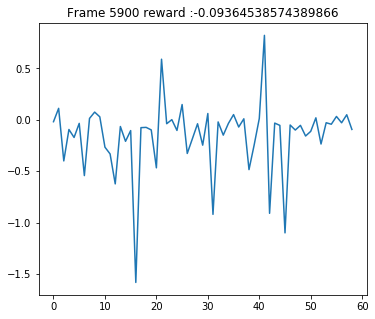

KeyboardInterrupt: 

In [103]:
states = env.reset()
while True:
    log_prob_list = []
    value_list = []
    reward_list = []
    mask_list = []
    entropy = 0

    
    for _ in range(num_steps):
        frame_idx += 1
        states_t = torch.tensor(states, dtype=torch.float).to(device)
        dists = actor(states_t)
        values = critic(states_t)

        actions = dists.sample()        
        actions_np = actions.cpu().numpy()
        actions_np = np.clip(actions_np, -1, 1)

        next_states, rewards, done, _ = env.step(actions_np)

        log_prob = dists.log_prob(actions)
        entropy += dists.entropy().mean()

        log_prob_list.append(log_prob.unsqueeze(0))
        value_list.append(values.unsqueeze(0))

        rewards_t = torch.tensor(rewards, dtype=torch.float).unsqueeze(-1).to(device)
        reward_list.append(rewards_t.unsqueeze(0))

        mask_t = torch.tensor(1-done, dtype= torch.float).unsqueeze(-1).to(device)
        mask_list.append(mask_t.unsqueeze(0))
        if done:
            states = env.reset()
        states = next_states    

        if frame_idx % 100 == 0:
            test_rewards.append(np.mean([test_env(env) for _ in range(10)]))
            plot(frame_idx, test_rewards)


    next_state_t = torch.tensor(next_states, dtype=torch.float).to(device)
    next_value = critic(next_state_t)
    returns = compute_returns(next_value, reward_list, mask_list)

    log_prob_t = torch.cat(log_prob_list)
    returns_t = torch.cat(returns)
    values = torch.cat(value_list)    

    advantage = returns_t - values
    assert returns_t.shape == values.shape, f"Different shape. returns_t : {returns_t.shape}, values : {values_t.shape}"

    actor_loss = -(log_prob_t * advantage.detach()).mean() - 0.001 * entropy
    critic_loss = nn.MSELoss()(returns_t, values) / 2

    total_loss = actor_loss + critic_loss

    actor_optimizer.zero_grad()
    critic_optimizer.zero_grad()

    actor_loss.backward()
    critic_loss.backward()

    actor_optimizer.step()
    critic_optimizer.step()

In [ ]:
 torch.save(actor.state_dict(), 'actor.pth')
 torch.save(critic.state_dict(), 'critic.pth')